# Project: Solving Lid-Driven Cavity Flow using Physics Informed Neural Network (PINN)

### Physics-Informed Neural Networks (PINN) are neural networks (NNs) that encode model equations as a component of the network itself and are increasingly popular for solving partial differential equations (PDEs) of nonlinear systems. 
#### We demonstrate the efficacy of PINNs in a lid-driven cavity flow problem, a classical benchmark to judge the accuracy of new computational methods for incompressible Navier–Stokes equations. 

#### <img src="./equation.png" width="500" align="center"/>

#### <img src="./domain.png" width="500" align="center"/>

### First, in the forward problem, we use PINN to solve the steady-state governing equation. 
### Further, given a previously obtained dataset of measurements of velocity and pressure over the spatial domain, we reconstruct the entire flow field by sampling only a limited number of data points from a patch inside the domain. 

#### Import packages

In [102]:
from __future__ import print_function

import torch
from pyDOE import lhs
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import scipy.io
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

np.random.seed(1234)

In [3]:
print("Cuda availability: ", torch.cuda.is_available())
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

Cuda availability:  False


## Part (1) Forward problem: Compute the Solution using PINN

#### Network setup:

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 20), nn.Tanh(),

            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),

            nn.Linear(20, 2))                    
        
    def forward(self, x):
        return self.net(x)

#### Evaluate the derivatives using auto-differentiation and constrcut the PDE

In [17]:
def function(self, x, y):
    nu = 0.01   # Re = 100

    res = self.net(torch.hstack((x, y)))
    psi, p = res[:, 0:1], res[:, 1:2]    # NN output: velocity field and pressure field 

    u = torch.autograd.grad(psi, y, grad_outputs=torch.ones_like(psi), create_graph=True)[0].to(device)
    v = -1.*torch.autograd.grad(psi, x, grad_outputs=torch.ones_like(psi), create_graph=True)[0].to(device)

    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0].to(device)
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0].to(device)
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0].to(device)
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0].to(device)

    v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0].to(device)
    v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)[0].to(device)
    v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), create_graph=True)[0].to(device)
    v_yy = torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(v_y), create_graph=True)[0].to(device)

    p_x = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p), create_graph=True)[0].to(device)
    p_y = torch.autograd.grad(p, y, grad_outputs=torch.ones_like(p), create_graph=True)[0].to(device)

    f = u * u_x + v * u_y + p_x - nu * (u_xx + u_yy)
    g = u * v_x + v * v_y + p_y - nu * (v_xx + v_yy)

    return u, v, p, f, g

#### Prepare boundary and residual data points for training

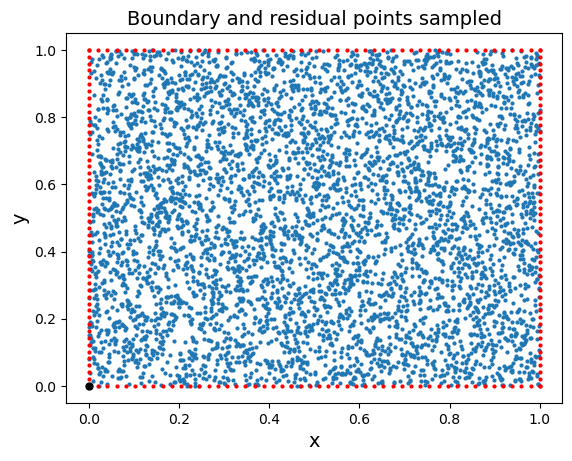

In [239]:
######### Origin ##########
x_origin = np.array([[0.]])
y_origin = np.array([[0.]])
x_origin_in = Variable(torch.from_numpy(np.reshape(x_origin, (-1, 1))).float(), requires_grad = True).to(device)
y_origin_in = Variable(torch.from_numpy(np.reshape(y_origin, (-1, 1))).float(), requires_grad = True).to(device) 


##### Boundary points #####
boundary_num = 50

# upper boundary
x_up = np.linspace(0., 1., boundary_num)
y_up = np.ones(boundary_num)
x_up_in = Variable(torch.from_numpy(np.reshape(x_up, (-1, 1))).float(), requires_grad = True).to(device)
y_up_in = Variable(torch.from_numpy(np.reshape(y_up, (-1, 1))).float(), requires_grad = True).to(device)   

# lower boundary
x_low = np.linspace(0., 1., boundary_num)
y_low = np.zeros(boundary_num)
x_low_in = Variable(torch.from_numpy(np.reshape(x_low, (-1, 1))).float(), requires_grad = True).to(device)
y_low_in = Variable(torch.from_numpy(np.reshape(y_low, (-1, 1))).float(), requires_grad = True).to(device)      

# left boundary
x_left = np.zeros(boundary_num)
y_left = np.linspace(0., 1., boundary_num)
x_left_in = Variable(torch.from_numpy(np.reshape(x_left, (-1, 1))).float(), requires_grad = True).to(device)
y_left_in = Variable(torch.from_numpy(np.reshape(y_left, (-1, 1))).float(), requires_grad = True).to(device)   

# right boundary
x_right = np.ones(boundary_num) 
y_right = np.linspace(0., 1., boundary_num)
x_right_in = Variable(torch.from_numpy(np.reshape(x_right, (-1, 1))).float(), requires_grad = True).to(device)
y_right_in = Variable(torch.from_numpy(np.reshape(y_right, (-1, 1))).float(), requires_grad = True).to(device)  


##### Residual points #####
res_num = 5000
res_pts = lhs(2, res_num)

x_res = res_pts[:, 0]
y_res = res_pts[:, 1]
x_res_in = Variable(torch.from_numpy(np.reshape(x_res, (-1, 1))).float(), requires_grad = True).to(device)
y_res_in = Variable(torch.from_numpy(np.reshape(y_res, (-1, 1))).float(), requires_grad = True).to(device)


######### Plotting ########
plt.plot(x_res, y_res, "o", markersize=2)
plt.plot(x_up, y_up, "ro", markersize=2)
plt.plot(x_left, y_left, "ro", markersize=2)
plt.plot(x_right, y_right, "ro", markersize=2)
plt.plot(x_low, y_low, "ro", markersize=2)
plt.plot(x_origin, y_origin, "ko", markersize=5)

plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)
plt.title("Boundary and residual points sampled", fontsize=14)
plt.show()

#### Train network (using Adam followed by LBFGS optmizer):

In [ ]:
net = Net()
print(net)
net = net.to(device)

##### Xavier Initialization #####
for m in net.modules():
    if isinstance(m, (nn.Linear)):
        torch.nn.init.xavier_normal_(m.weight)


##### Loss Function #####
mse_loss_func = torch.nn.MSELoss()
optimizer_adam = torch.optim.Adam(net.parameters(), lr=0.001)
loss_Adam = []

optimizer_LBFGS = torch.optim.LBFGS(net.parameters(), history_size=8, max_iter=500000)
loss_LBFGS = []


######### Training ########

#### Adam ####
N_iter_Adam = 10001
print("------ IN Adam ------")
for n in range(N_iter_Adam):
    def closure():
        optimizer_adam.zero_grad()
        
        ##### Origin #####
        u_origin, v_origin, p_origin, f_origin, g_origin = function(net, x_origin_in, y_origin_in)
        zero = torch.zeros(1, 1).to(device)
        loss_origin = mse_loss_func(p_origin, zero)     # pressure is 0 at origin

        ##### Boundary #####
        boundary_num = x_up_in.shape[0]
        zeros = torch.zeros(boundary_num, 1).to(device)
        ones = torch.ones(boundary_num, 1).to(device)

        # upper boundary 
        u_up, v_up, p_up, f_up, g_up = function(net, x_up_in, y_up_in)
        u_loss_up = mse_loss_func(u_up, ones)           # u = 1 at upper boundary 
        v_loss_up = mse_loss_func(v_up, zeros)          # v = 0 at upper boundary 
        loss_up = u_loss_up + v_loss_up

        # lower boundary 
        u_low, v_low, p_low, f_low, g_low = function(net, x_low_in, y_low_in)
        u_loss_low = mse_loss_func(u_low, zeros)        # u = 0 at lower boundary 
        v_loss_low = mse_loss_func(v_low, zeros)        # v = 0 at lower boundary 
        loss_low = u_loss_low + v_loss_low

        # left boundary 
        u_left, v_left, p_left, f_left, g_left = function(net, x_left_in, y_left_in)
        u_loss_left = mse_loss_func(u_left, zeros)      # u = 0 at lower boundary
        v_loss_left = mse_loss_func(v_left, zeros)      # v = 0 at lower boundary
        loss_left = u_loss_left + v_loss_left

        # right boundary 
        u_right, v_right, p_right, f_right, g_right = function(net, x_right_in, y_right_in)
        u_loss_right = mse_loss_func(u_right, zeros)        # u = 0 at lower boundary
        v_loss_right = mse_loss_func(v_right, zeros)        # v = 0 at lower boundary
        loss_right = u_loss_right + v_loss_right

        ##### Residual #####
        res_num = x_res_in.shape[0]
        zeros1 = torch.zeros(res_num, 1).to(device)

        u_res, v_res, p_res, f_res, g_res = function(net, x_res_in, y_res_in)
        f_loss_res = mse_loss_func(f_res, zeros1)       # to satisfy the PDE
        g_loss_res = mse_loss_func(g_res, zeros1)       # to satisfy the PDE
        loss_res = f_loss_res + g_loss_res

        # LOSS FUNCTION:
        loss = loss_origin + loss_up + loss_low + loss_left + loss_right + loss_res 
        loss.backward()
        return loss
       
    optimizer_adam.step(closure)
    loss = closure() 
    loss_Adam.append(loss.cpu().detach().numpy())
    
    if n%100 == 0:
        print("Adam - Epoch: ", n, "Training Loss: ", loss.item())


#### LBFGS ####
N_iter_LBFGS = 20
print("------ IN LBFGS ------")
for n in range(N_iter_LBFGS):
    def closure():
        optimizer_LBFGS.zero_grad()
        
        ##### Origin #####
        u_origin, v_origin, p_origin, f_origin, g_origin = function(net, x_origin_in, y_origin_in)
        zero = torch.zeros(1, 1).to(device)
        loss_origin = mse_loss_func(p_origin, zero)     # pressure is 0 at origin

        ##### Boundary #####
        boundary_num = x_up_in.shape[0]
        zeros = torch.zeros(boundary_num, 1).to(device)
        ones = torch.ones(boundary_num, 1).to(device)

        # upper boundary 
        u_up, v_up, p_up, f_up, g_up = function(net, x_up_in, y_up_in)
        u_loss_up = mse_loss_func(u_up, ones)           # u = 1 at upper boundary 
        v_loss_up = mse_loss_func(v_up, zeros)          # v = 0 at upper boundary 
        loss_up = u_loss_up + v_loss_up

        # lower boundary 
        u_low, v_low, p_low, f_low, g_low = function(net, x_low_in, y_low_in)
        u_loss_low = mse_loss_func(u_low, zeros)        # u = 0 at lower boundary 
        v_loss_low = mse_loss_func(v_low, zeros)        # v = 0 at lower boundary 
        loss_low = u_loss_low + v_loss_low

        # left boundary 
        u_left, v_left, p_left, f_left, g_left = function(net, x_left_in, y_left_in)
        u_loss_left = mse_loss_func(u_left, zeros)      # u = 0 at lower boundary
        v_loss_left = mse_loss_func(v_left, zeros)      # v = 0 at lower boundary
        loss_left = u_loss_left + v_loss_left

        # right boundary 
        u_right, v_right, p_right, f_right, g_right = function(net, x_right_in, y_right_in)
        u_loss_right = mse_loss_func(u_right, zeros)        # u = 0 at lower boundary
        v_loss_right = mse_loss_func(v_right, zeros)        # v = 0 at lower boundary
        loss_right = u_loss_right + v_loss_right

        ##### Residual #####
        res_num = x_res_in.shape[0]
        zeros1 = torch.zeros(res_num, 1).to(device)

        u_res, v_res, p_res, f_res, g_res = function(net, x_res_in, y_res_in)
        f_loss_res = mse_loss_func(f_res, zeros1)       # to satisfy the PDE
        g_loss_res = mse_loss_func(g_res, zeros1)       # to satisfy the PDE
        loss_res = f_loss_res + g_loss_res

        # LOSS FUNCTION:
        loss = loss_origin + loss_up + loss_low + loss_left + loss_right + loss_res 
        loss.backward()
        return loss

    optimizer_LBFGS.step(closure)
    loss = closure() 
    loss_LBFGS.append(loss.cpu().detach().numpy())
    
    print("LBFGS - Epoch: ", n, "Training Loss: ", loss.item())

Net(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Tanh()
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): Tanh()
    (8): Linear(in_features=20, out_features=20, bias=True)
    (9): Tanh()
    (10): Linear(in_features=20, out_features=20, bias=True)
    (11): Tanh()
    (12): Linear(in_features=20, out_features=20, bias=True)
    (13): Tanh()
    (14): Linear(in_features=20, out_features=2, bias=True)
  )
)
------ IN Adam ------
Adam - Epoch:  0 Training Loss:  1.061879277229309
Adam - Epoch:  100 Training Loss:  0.08023711293935776
Adam - Epoch:  200 Training Loss:  0.07755573838949203
Adam - Epoch:  300 Training Loss:  0.07720281928777695
Adam - Epoch:  400 Training Loss:  0.07715955376625061
Adam - Epoch:  500 Training Loss:  0.07655934989452362
Adam - Epoch:  600 Traini

#### Plot training losses over the epochs
#### Notice the sharp decline in training loss after applying the LBFGS optmizer

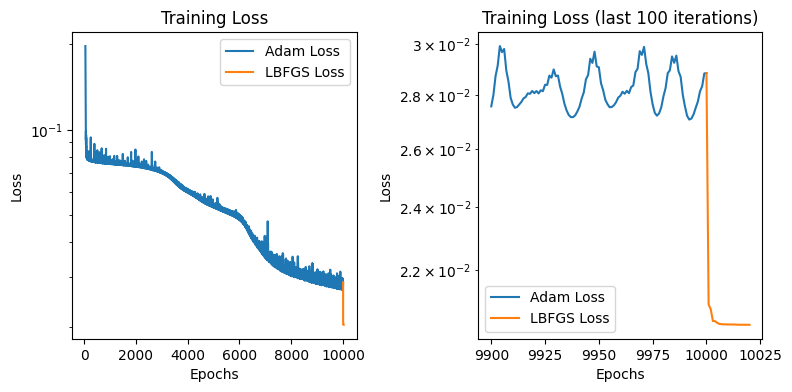

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=False)

ep1 = np.arange(50, N_iter_Adam)
ep2 = np.arange(N_iter_Adam - 1, N_iter_Adam + N_iter_LBFGS)

loss_LBFGS1 = [loss_Adam[-1]] + loss_LBFGS
axs[0].semilogy(ep1, loss_Adam[50:], label="Adam Loss")
axs[0].semilogy(ep2, loss_LBFGS1, label="LBFGS Loss")
axs[0].legend()
axs[0].set_title('Training Loss' )
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')

ep3 = np.arange(9900, N_iter_Adam)
ep4 = np.arange(N_iter_Adam - 1, N_iter_Adam + N_iter_LBFGS)
axs[1].semilogy(ep3, loss_Adam[9900:], label="Adam Loss")
axs[1].semilogy(ep4, loss_LBFGS1, label="LBFGS Loss")
axs[1].legend()
axs[1].set_title('Training Loss (last 100 iterations)' )
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')

fig.tight_layout(pad=1.0)
plt.show()

#### Graph the PINN solution for the Lid-Driven Cavity Flow problem

In [ ]:
def find_uvp(X, Y, N_plt):
    XX = Variable(torch.from_numpy(X.reshape(-1,1)).float(), requires_grad = True).to(device)
    YY = Variable(torch.from_numpy(Y.reshape(-1,1)).float(), requires_grad = True).to(device)
    uu, vv, pp, ff, gg = function(net, XX, YY)
    u = uu.cpu().detach().numpy().reshape(-N_plt,N_plt)
    v = vv.cpu().detach().numpy().reshape(-N_plt,N_plt)
    p = pp.cpu().detach().numpy().reshape(-N_plt,N_plt)
    return u, v, p

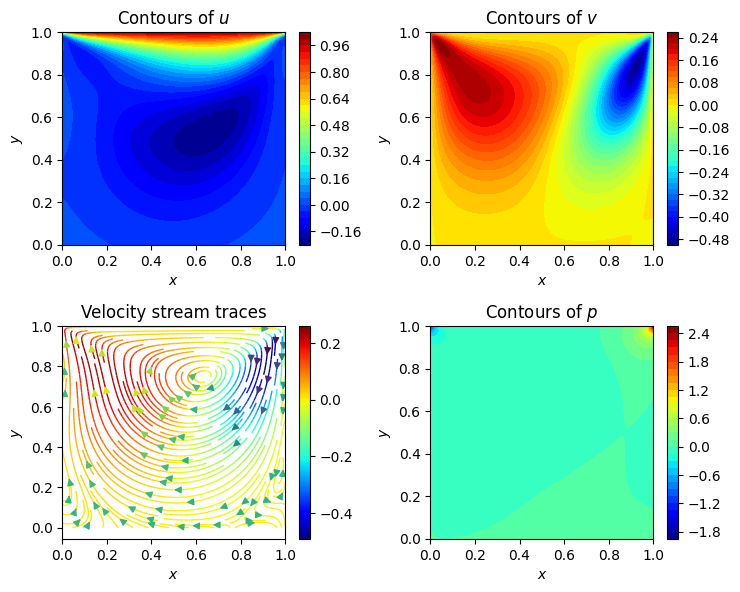

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(7.5, 6), sharey=False)
N_plt = 200

xlist = np.linspace(0., 1., N_plt)
ylist = np.linspace(0., 1., N_plt)
X, Y = np.meshgrid(xlist, ylist)
u, v, p = find_uvp(X, Y, N_plt)

N_resolution = 40
### Plot u ###
cp_u = axs[0, 0].contourf(X, Y, u, N_resolution)
fig.colorbar(cp_u) 
cp_u.set_cmap('jet')
axs[0, 0].set_title('Contours of $u$')
axs[0, 0].set_xlabel('$x$')
axs[0, 0].set_ylabel('$y$')

### Plot v ###
cp_v = axs[0, 1].contourf(X, Y, v, N_resolution)
fig.colorbar(cp_v) 
cp_v.set_cmap('jet')
axs[0, 1].set_title('Contours of $v$')
axs[0, 1].set_xlabel('$x$')
axs[0, 1].set_ylabel('$y$')

### Plot velocity field ###
strm = axs[1, 0].streamplot(X, Y, u, v, color=v, density=1.5, linewidth=1)
fig.colorbar(strm.lines)
strm.lines.set_cmap('jet')
axs[1, 0].set_title('Velocity stream traces' )
axs[1, 0].set_xlabel('$x$')
axs[1, 0].set_ylabel('$y$')

### Plot p ###
cp_p = axs[1, 1].contourf(X, Y, p, N_resolution)
fig.colorbar(cp_p) 
cp_p.set_cmap('jet')
axs[1, 1].set_title('Contours of $p$')
axs[1, 1].set_xlabel('$x$')
axs[1, 1].set_ylabel('$y$')

fig.tight_layout(pad=1.0)
plt.show()

## Part (2) Recover the flow for the entire domain from data points randomly sampled inside a patch

#### Prepare data: points randomly sampled from a patch inside the domain.

In [11]:
# Load data from .mat file
velocity_data = scipy.io.loadmat('./velocity.mat')
pressure_data = scipy.io.loadmat('./pressure.mat')

# already flattened data
x = velocity_data['x'].T # 20201 x 1
y = velocity_data['y'].T # 20201 x 1
u = velocity_data['u'].T # 20201 x 1
v = velocity_data['v'].T # 20201 x 1
p = pressure_data['p'].T # 20201 x 1

In [13]:
# randomly sample N points from a square patch
def sample_in_patch(N, left, right):
    len = x.shape[0]
    x_train = np.array([])
    y_train = np.array([])
    u_train = np.array([])
    v_train = np.array([])
    p_train = np.array([])
    
    i = 0
    while i <= N:
        idx = np.random.choice(len, 1, replace=False)
        x_sample = x[idx,:]
        y_sample = y[idx,:]
        u_sample = u[idx,:]
        v_sample = v[idx,:]
        p_sample = p[idx,:]
        
        if left <= x_sample <= right and left <= y_sample <= right: # within the patch
            i = i + 1
            x_train = np.append(x_train, x_sample)
            y_train = np.append(y_train, y_sample)
            u_train = np.append(u_train, u_sample)
            v_train = np.append(v_train, v_sample)
            p_train = np.append(p_train, p_sample)      
   
    return x_train, y_train, u_train, v_train, p_train

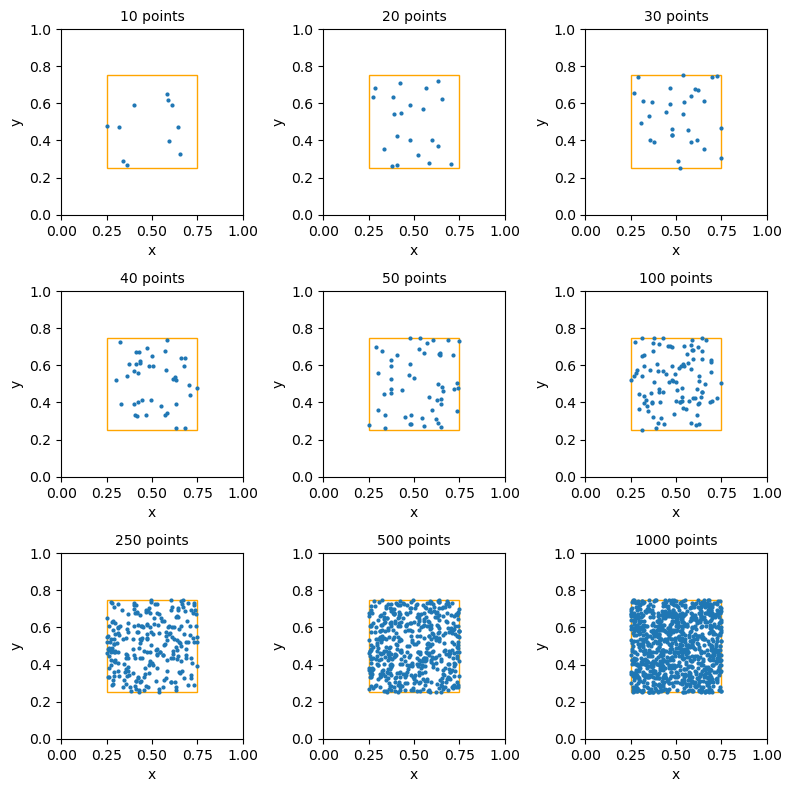

In [172]:
# Sample random points inside the sqaure patch
left = 0.25
right = 0.75

x_10, y_10, u_10, v_10, p_10 = sample_in_patch(10, left, right)
x_20, y_20, u_20, v_20, p_20 = sample_in_patch(20, left, right)
x_30, y_30, u_30, v_30, p_30 = sample_in_patch(30, left, right)
x_40, y_40, u_40, v_40, p_40 = sample_in_patch(40, left, right)
x_50, y_50, u_50, v_50, p_50 = sample_in_patch(50, left, right)
x_100, y_100, u_100, v_100, p_100 = sample_in_patch(100, left, right)
x_250, y_250, u_250, v_250, p_250 = sample_in_patch(250, left, right)
x_500, y_500, u_500, v_500, p_500 = sample_in_patch(500, left, right)
x_1000, y_1000, u_1000, v_1000, p_1000 = sample_in_patch(1000, left, right)


# Visualize the sampled points
fig, axs = plt.subplots(3, 3, figsize=(8, 8), sharey=False)

axs[0, 0].set_xlim(0, 1)
axs[0, 0].set_ylim(0, 1)
axs[0, 0].plot(x_10, y_10, "o", markersize=2)
axs[0, 0].add_patch(Rectangle((left, left), 0.5, 0.5, edgecolor = 'orange', fill=False))
axs[0, 0].set_xlabel("x")
axs[0, 0].set_ylabel("y")
axs[0, 0].set_title("10 points", fontsize=10)

axs[0, 1].set_xlim(0, 1)
axs[0, 1].set_ylim(0, 1)
axs[0, 1].plot(x_20, y_20, "o", markersize=2)
axs[0, 1].add_patch(Rectangle((left, left), 0.5, 0.5, edgecolor = 'orange', fill=False))
axs[0, 1].set_xlabel("x")
axs[0, 1].set_ylabel("y")
axs[0, 1].set_title("20 points", fontsize=10)

axs[0, 2].set_xlim(0, 1)
axs[0, 2].set_ylim(0, 1)
axs[0, 2].plot(x_30, y_30, "o", markersize=2)
axs[0, 2].add_patch(Rectangle((left, left), 0.5, 0.5, edgecolor = 'orange', fill=False))
axs[0, 2].set_xlabel("x")
axs[0, 2].set_ylabel("y")
axs[0, 2].set_title("30 points", fontsize=10)

axs[1, 0].set_xlim(0, 1)
axs[1, 0].set_ylim(0, 1)
axs[1, 0].plot(x_40, y_40, "o", markersize=2)
axs[1, 0].add_patch(Rectangle((left, left), 0.5, 0.5, edgecolor = 'orange', fill=False))
axs[1, 0].set_xlabel("x")
axs[1, 0].set_ylabel("y")
axs[1, 0].set_title("40 points", fontsize=10)

axs[1, 1].set_xlim(0, 1)
axs[1, 1].set_ylim(0, 1)
axs[1, 1].plot(x_50, y_50, "o", markersize=2)
axs[1, 1].add_patch(Rectangle((left, left), 0.5, 0.5, edgecolor = 'orange', fill=False))
axs[1, 1].set_xlabel("x")
axs[1, 1].set_ylabel("y")
axs[1, 1].set_title("50 points", fontsize=10)

axs[1, 2].set_xlim(0, 1)
axs[1, 2].set_ylim(0, 1)
axs[1, 2].plot(x_100, y_100, "o", markersize=2)
axs[1, 2].add_patch(Rectangle((left, left), 0.5, 0.5, edgecolor = 'orange', fill=False))
axs[1, 2].set_xlabel("x")
axs[1, 2].set_ylabel("y")
axs[1, 2].set_title("100 points", fontsize=10)

axs[2, 0].set_xlim(0, 1)
axs[2, 0].set_ylim(0, 1)
axs[2, 0].plot(x_250, y_250, "o", markersize=2)
axs[2, 0].add_patch(Rectangle((left, left), 0.5, 0.5, edgecolor = 'orange', fill=False))
axs[2, 0].set_xlabel("x")
axs[2, 0].set_ylabel("y")
axs[2, 0].set_title("250 points", fontsize=10)

axs[2, 1].set_xlim(0, 1)
axs[2, 1].set_ylim(0, 1)
axs[2, 1].plot(x_500, y_500, "o", markersize=2)
axs[2, 1].add_patch(Rectangle((left, left), 0.5, 0.5, edgecolor = 'orange', fill=False))
axs[2, 1].set_xlabel("x")
axs[2, 1].set_ylabel("y")
axs[2, 1].set_title("500 points", fontsize=10)

axs[2, 2].set_xlim(0, 1)
axs[2, 2].set_ylim(0, 1)
axs[2, 2].plot(x_1000, y_1000, "o", markersize=2)
axs[2, 2].add_patch(Rectangle((left, left), 0.5, 0.5, edgecolor = 'orange', fill=False))
axs[2, 2].set_xlabel("x")
axs[2, 2].set_ylabel("y")
axs[2, 2].set_title("1000 points", fontsize=10)

fig.tight_layout(pad=1.0)
plt.show()

#### Reconstruction of the flow by running a regression using the data points

In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 20), nn.Tanh(),

            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),

            nn.Linear(20, 2))                    
        
    def forward(self, x):
        return self.net(x)

#### Using only 10 data points:

------ In Adam ------
Adam - Epoch:  0 Training Loss:  0.3856089115142822
Adam - Epoch:  100 Training Loss:  0.00532548176124692
Adam - Epoch:  200 Training Loss:  0.001871017855592072
Adam - Epoch:  300 Training Loss:  0.00157285132445395
Adam - Epoch:  400 Training Loss:  0.0013583616819232702
Adam - Epoch:  500 Training Loss:  0.0011780660133808851
Adam - Epoch:  600 Training Loss:  0.0009809080511331558
Adam - Epoch:  700 Training Loss:  0.0007992158061824739
Adam - Epoch:  800 Training Loss:  0.0007878995384089649
Adam - Epoch:  900 Training Loss:  0.0005909777246415615
Adam - Epoch:  1000 Training Loss:  0.0005609734216704965
Adam - Epoch:  1100 Training Loss:  0.00054442003602162
Adam - Epoch:  1200 Training Loss:  0.0005107220495119691
Adam - Epoch:  1300 Training Loss:  0.00047562416875734925
Adam - Epoch:  1400 Training Loss:  0.000494040665216744
Adam - Epoch:  1500 Training Loss:  0.00042144962935708463
Adam - Epoch:  1600 Training Loss:  0.00037336681270971894
Adam - Epoch

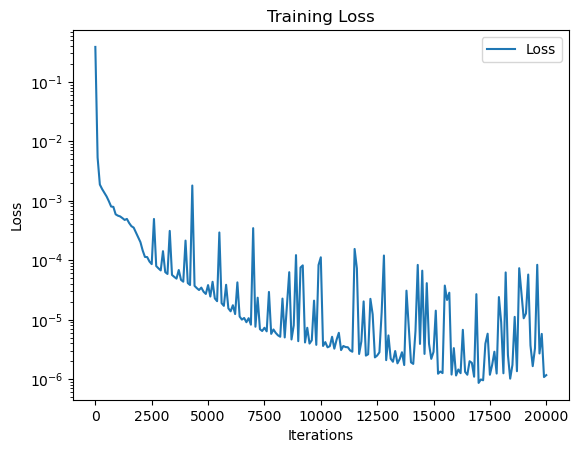

In [165]:
##### Define neural network #####
net10 = Net()
net10 = net10.to(device)


##### Prepare data for training #####
x_in = Variable(torch.from_numpy(x_10.reshape(-1,1)).float(), requires_grad = True).to(device)
y_in = Variable(torch.from_numpy(y_10.reshape(-1,1)).float(), requires_grad = True).to(device)
u_data = Variable(torch.from_numpy(u_10.reshape(-1,1)).float(), requires_grad = True).to(device)
v_data = Variable(torch.from_numpy(v_10.reshape(-1,1)).float(), requires_grad = True).to(device)
p_data = Variable(torch.from_numpy(p_10.reshape(-1,1)).float(), requires_grad = True).to(device)  


##### Xavier Initialization #####
for m in net10.modules():
    if isinstance(m, (nn.Linear)):
        torch.nn.init.xavier_normal_(m.weight)


##### Loss Function #####
mse_loss_func = torch.nn.MSELoss()
optimizer_adam = torch.optim.Adam(net10.parameters(), lr=0.001)
loss_Adam_10 = []


######### Training ########
N_iter_Adam = 20001
print("------ In Adam ------")
for n in range(N_iter_Adam):
    def closure():
        optimizer_adam.zero_grad()
        u_out, v_out, p_out, f_out, g_out = function(net10, x_in, y_in)
        # LOSS FUNCTION:
        u_loss = mse_loss_func(u_out, u_data) 
        v_loss = mse_loss_func(v_out, v_data) 
        p_loss = mse_loss_func(p_out, p_data) 
        loss = u_loss + v_loss + p_loss
        loss.backward()
        return loss
    
    optimizer_adam.step(closure)
    
    if n%100 == 0:
        loss = closure() 
        loss_Adam_10.append(loss.cpu().detach().numpy())
        print("Adam - Epoch: ", n, "Training Loss: ", loss.item())

######### Plot Loss over Epochs ########
ep1 = np.arange(1, N_iter_Adam + 1, 100)
plt.semilogy(ep1, loss_Adam_10, label="Loss")
plt.legend()
plt.title('Training Loss' )
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

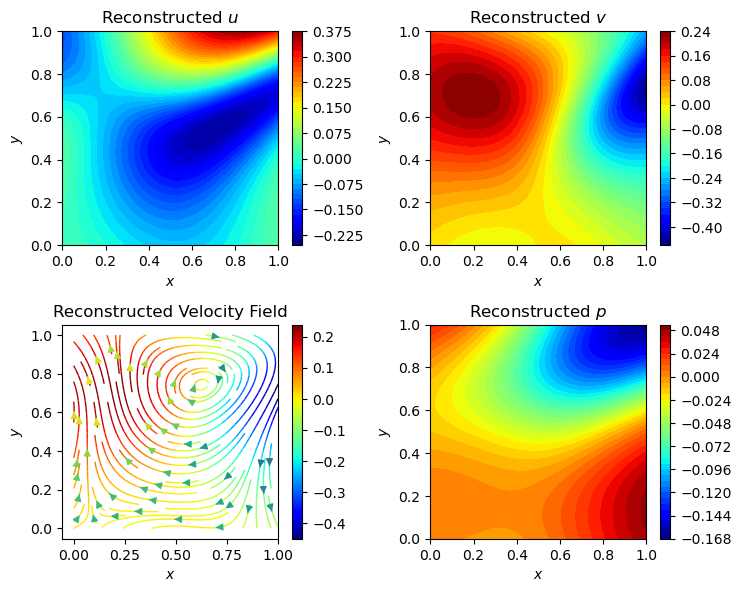

In [166]:
######### Plot Reconstructed Flow over the Entire Domain ########
def find_uvp(X, Y, N_plt):
    XX = Variable(torch.from_numpy(X.reshape(-1,1)).float(), requires_grad = True).to(device)
    YY = Variable(torch.from_numpy(Y.reshape(-1,1)).float(), requires_grad = True).to(device)
    uu, vv, pp, ff, gg = function(net10, XX, YY)
    u = uu.cpu().detach().numpy().reshape(-N_plt,N_plt)
    v = vv.cpu().detach().numpy().reshape(-N_plt,N_plt)
    p = pp.cpu().detach().numpy().reshape(-N_plt,N_plt)
    return u, v, p

fig, axs = plt.subplots(2, 2, figsize=(7.5, 6), sharey=False)
N_plt = 200      # number of points on each edge to construct the mesh to plot the flow
xlist = np.linspace(0., 1., N_plt)
ylist = np.linspace(0., 1., N_plt)
X, Y = np.meshgrid(xlist, ylist)
uu, vv, pp = find_uvp(X, Y, N_plt)

N_resolution = 40
### Plot u ###
cp_u = axs[0, 0].contourf(X, Y, uu, N_resolution)
fig.colorbar(cp_u) 
cp_u.set_cmap('jet')
axs[0, 0].set_title('Reconstructed $u$')
axs[0, 0].set_xlabel('$x$')
axs[0, 0].set_ylabel('$y$')

### Plot v ###
cp_v = axs[0, 1].contourf(X, Y, vv, N_resolution)
fig.colorbar(cp_v) 
cp_v.set_cmap('jet')
axs[0, 1].set_title('Reconstructed $v$')
axs[0, 1].set_xlabel('$x$')
axs[0, 1].set_ylabel('$y$')

### Plot velocity field ###
strm = axs[1, 0].streamplot(X, Y, uu, vv, color=vv, density=1, linewidth=1)
fig.colorbar(strm.lines)
strm.lines.set_cmap('jet')
axs[1, 0].set_title('Reconstructed Velocity Field' )
axs[1, 0].set_xlabel('$x$')
axs[1, 0].set_ylabel('$y$')

### Plot p ###
cp_p = axs[1, 1].contourf(X, Y, pp, N_resolution)
fig.colorbar(cp_p) 
cp_p.set_cmap('jet')
axs[1, 1].set_title('Reconstructed $p$')
axs[1, 1].set_xlabel('$x$')
axs[1, 1].set_ylabel('$y$')

fig.tight_layout(pad=1.0)
plt.show()

#### The results are not too bad! Even when only 10 data points are used for this training. 

In [167]:
######### Calculate MSE loss between reconstructed and actual flow field ########
N_test = 1000
len = x.shape[0]

U_loss = []
P_loss = []

for i in range(100):     # calculate the l2 loss for 50 times
    idx = np.random.choice(len, N_test, replace=False)      # randomly select N_test data points
    x_test = x[idx,:]
    y_test = y[idx,:]
    u_test = u[idx,:]
    v_test = v[idx,:]
    p_test = p[idx,:]     # testing data

    x_in = Variable(torch.from_numpy(x_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    y_in = Variable(torch.from_numpy(y_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    u_test = Variable(torch.from_numpy(u_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    v_test = Variable(torch.from_numpy(v_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    p_test = Variable(torch.from_numpy(p_test.reshape(-1,1)).float(), requires_grad = True).to(device) 

    u_out, v_out, p_out, f_out, g_out = function(net10, x_in, y_in)     # evaluate
    u_loss = mse_loss_func(u_out, u_test) 
    v_loss = mse_loss_func(v_out, v_test) 
    velocity_loss = u_loss + v_loss
    p_loss = mse_loss_func(p_out, p_test) 

    U_loss.append(velocity_loss.cpu().detach().numpy())
    P_loss.append(p_loss.cpu().detach().numpy())

print(np.mean(U_loss))      # report the mean of the loss 
print(np.std(U_loss))  
print(np.mean(P_loss))
print(np.std(P_loss))

0.0270777
0.0029438208
0.014230136
0.008595935
